In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools

comment = "Load saved realizations and plot"

import pickle

In [2]:
file_clip = open("core_nb_sh_core_swarm_A_small_obs.obj", "rb")
core = pickle.load(file_clip)

In [3]:
grid_in = np.array([core.grid_glq_phi, 90-core.grid_glq_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)

In [4]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               SH30 run with real observations from swarm A
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  60
sim_type:              core
grid_glq_zero:         (31,), Max/Min: 1.00 / -1.00
grid_glq_w_shtools:    (31,), Max/Min: 0.10 / 0.01
grid_glq_shape:        (2,), Max/Min: 61.00 / 31.00
grid_glq_w:            (1891,), Max/Min: 0.10 / 0.01
grid_glq_radial:       (1891,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (1891,), Max/Min: 175.63 / 4.37
grid_glq_phi:          (1891,), Max/Min: 354.10 / 0.00
grid_glq_N:            1891
grid_glq_nmax:         30
r_grid:                3480.0
grid:                  (1891, 2)
lon:                   (1891,), Max/Min: 354.10 / 0.00
lat:                   (1891,), Max/Min: 

In [5]:
core.sv_model_lags = len(core.lags_model)
core.sv_max_dist = 7000
core.sv_lag_length = 50
core.sv_zero_nugget = True

In [6]:
core.semivar(model_lags = core.sv_model_lags, model = core.model, max_dist = core.sv_max_dist, lag_length = core.sv_lag_length, zero_nugget = core.sv_zero_nugget)

#core.condtab(normsize=10000)

____semi-variogram setup___

Number of data used: 2478369
Max data distance: 6999.883 km
Lag length chosen: 50.0 km
Number of lags: 139
Number of modelling lags: 24

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


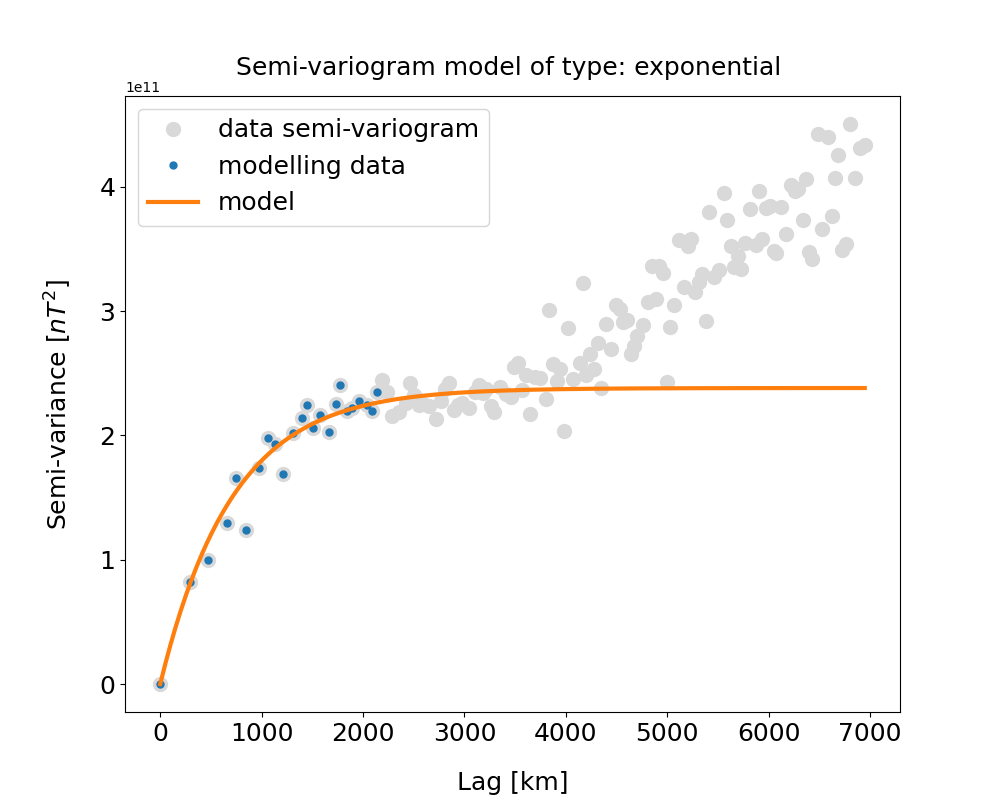

In [7]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(core.lags_model,core.pics_model,'.',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C1',linewidth = 3,label='model')
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

# Synthetic sat

In [8]:
file_clip = open("sat_nb_sh_core_swarm_A_small_obs.obj", "rb")
s_sat = pickle.load(file_clip)

In [9]:
print(s_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          SH30 run with real observations from swarm A
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             60
sim_type:         sat
swarm_theta:      (2773,), Max/Min: 177.35 / 22.39
swarm_phi:        (2773,), Max/Min: 179.68 / -179.59
swarm_radius:     (2773,), Max/Min: 6825.19 / 6806.85
swarm_obs:        (2773,), Max/Min: 53117.43 / -48881.72
swarm_N:          2773
data:             (2773,), Max/Min: 53117.43 / -48881.72
target_var:       922024852.055313
target_mean_true: 10957.13228272629
target_mean:      0.0
r_grid:           (2773,), Max/Min: 6825.19 / 6806.85
grid:             (2773, 2)
sph_d:            None
lon:              (2773,), Max/Min: 179.68 / -179.59
lat:              (2773,), Max/Min: 67.61 / -87.35
N_grid:           2773



<IPython.core.display.Javascript object>


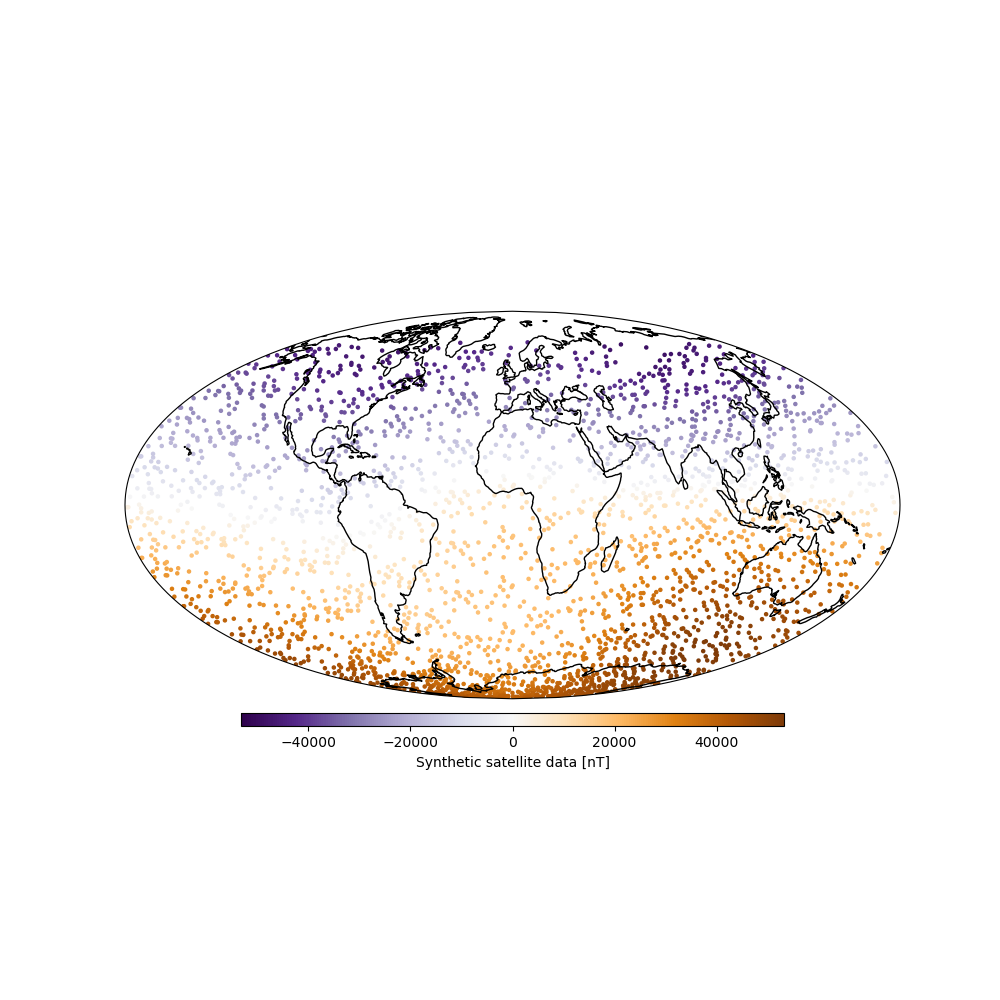

In [10]:
mt_util.plot_cartopy_global(lat = s_sat.lat, lon = s_sat.lon, plot_quality = "high", point_size=5, 
                            data=s_sat.data, cmap = 'PuOr_r', title="Synthetic satellite data")

In [11]:
G_r = mt_util.Gr_vec(core.r_grid, s_sat.r_grid, core.lat, s_sat.lat, core.lon, s_sat.lon)
G_d = np.pi/(core.grid_glq_nmax+0.5)*np.multiply(core.grid_glq_w,G_r) # +0.5 for parity with SHTOOLS

<IPython.core.display.Javascript object>


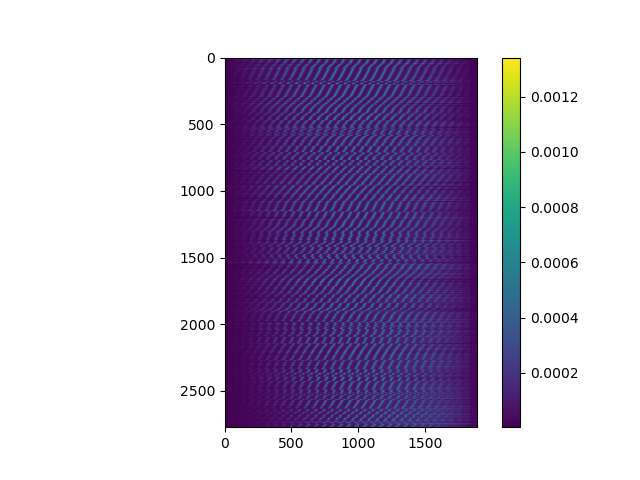

In [12]:
plt.figure()
plt.imshow(G_d)
plt.colorbar()


Gauss-Legendre RMSE:	 4.839


<IPython.core.display.Javascript object>


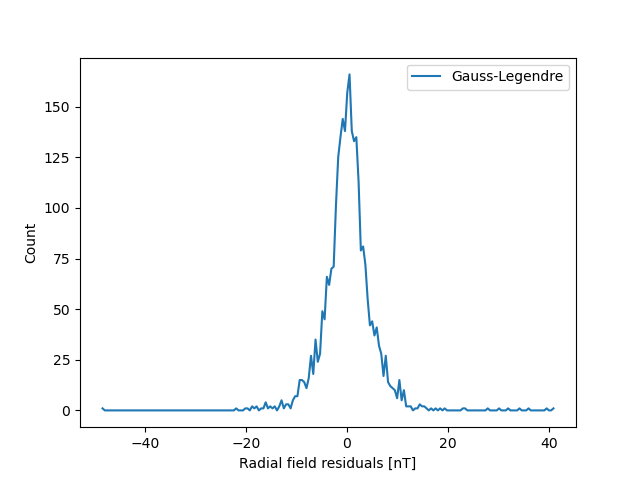

In [13]:
errorstd = 5
errorvar = errorstd**2

def covmod_lsq_equiv(obs,semivar,target_var,G_d,title="",errorvar = 10e2):
    a_0 = np.empty([0,])
    b_0 = obs
    d_0 = b_0

    G = G_d.copy()
    C_M = target_var - semivar
    C_D = np.zeros((len(a_0)+len(b_0),len(a_0)+len(b_0)))
    C_D[np.arange(len(a_0)+1,len(a_0)+len(b_0)),np.arange(len(a_0)+1,len(a_0)+len(b_0))] = errorvar
    S = C_D + G*C_M*G.T
    T = np.linalg.inv(S)
    m_equiv_lsq = C_M*G.T*T*d_0
    lsq_equiv_pred = G_d*m_equiv_lsq
    lsq_equiv_res = obs - lsq_equiv_pred
    return m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res

m_equiv_lsq, lsq_equiv_pred, lsq_equiv_res = covmod_lsq_equiv(s_sat.data.reshape(-1,1),core.sv_lut,core.target_var,G_d,title="Gauss-Legendre equivalent LSQ solution",errorvar = errorvar)

# RMSE
rmse_leg = np.sqrt(np.mean(np.power(lsq_equiv_res,2)))
print("")
print("Gauss-Legendre RMSE:\t %0.3f" %rmse_leg)
plt.figure()
y,binEdges=np.histogram(lsq_equiv_res,bins=200)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters,y,'C0',label="Gauss-Legendre")
plt.xlabel("Radial field residuals [nT]")
plt.ylabel("Count")
plt.legend()
plt.show()

#sds_util.plot_cartopy_global_new(core.lat, core.lon, data=np.ravel(m_equiv_lsq), plot_quality = "high", cmap = 'PuOr_r', title="Gauss-Legendre equivalent LSQ solution", scale_uneven = False)

<IPython.core.display.Javascript object>


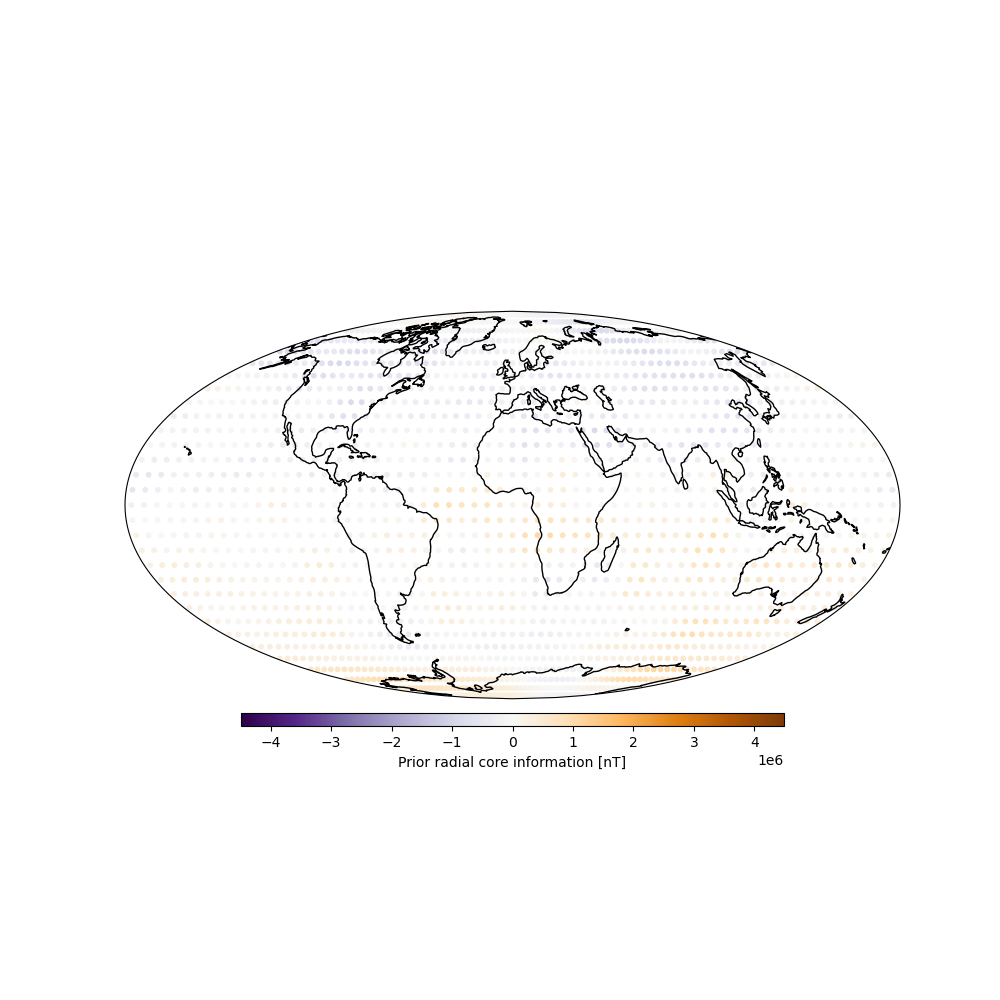

In [14]:
mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
                            data=np.ravel(m_equiv_lsq), point_size=10,
                            shape = (121,61), cmap = 'PuOr_r', 
                            title="Prior radial core information", limits_data = core.data)

In [15]:
#%% GREENS CORE
print(G_d.shape)
G_k = G_d*(core.target_var-core.sv_lut)
print(G_k.shape)
GG_K = G_k*G_d.T  + np.diag(errorvar*np.ones(s_sat.swarm_N,))
print(GG_K.shape)
sort_support = np.flipud(np.argsort(G_k,axis=0))
idx_data_support = sort_support

(2773, 1891)
(2773, 1891)
(2773, 2773)


In [16]:
N_sim = core.zs.shape[1]

In [17]:
seqsim_pred = G_d*core.zs
seqsim_res = s_sat.data.reshape(-1,1) - seqsim_pred

rmse_leg = np.sqrt(np.mean(np.power(seqsim_res,2),axis=0))
print("")
print("Seqsim RMSE:\t {}".format(rmse_leg))


Seqsim RMSE:	 [[5.02965933 5.02598542 5.05372139 5.0308984  5.03550217 5.08748732
  5.02352563 5.06294284 5.02566632 5.0431667  5.03766653 5.04210772
  5.05658183 5.05261463 5.05611869 5.06851531 5.05797798 5.04890512
  5.0606571  5.04036671 5.06987336 5.07014259 5.028159   5.04147754
  5.04206713 5.00966733 5.0419813  5.07195458 5.05604086 5.06465457
  5.03757263 5.07839801 5.03771288 5.07717958 5.03603326 5.09506779
  5.00619208 5.05039399 5.04474659 5.04996982 5.04322752 5.04197616
  5.01966079 5.04520673 5.05102951 5.01659965 4.98232929 5.07549926
  5.01028897 5.12716781 5.0296623  5.19283233 5.05788508 4.99190781
  5.12226794 5.02502549 5.01032763 5.03007525 5.0201277  5.04043468
  5.05057787 5.01422308 5.05737111 5.03809018 5.08365355 5.04621224
  5.01769792 5.03489695 5.03678232 5.06582248 5.0346298  5.06120913
  5.05723122 5.02242394 5.04072707 5.03767178 5.04139812 5.05468467
  5.08327508 5.00927488 5.03687189 5.05905862 5.06774762 5.07457893
  5.05091195 5.02542314 5.0124967

<IPython.core.display.Javascript object>


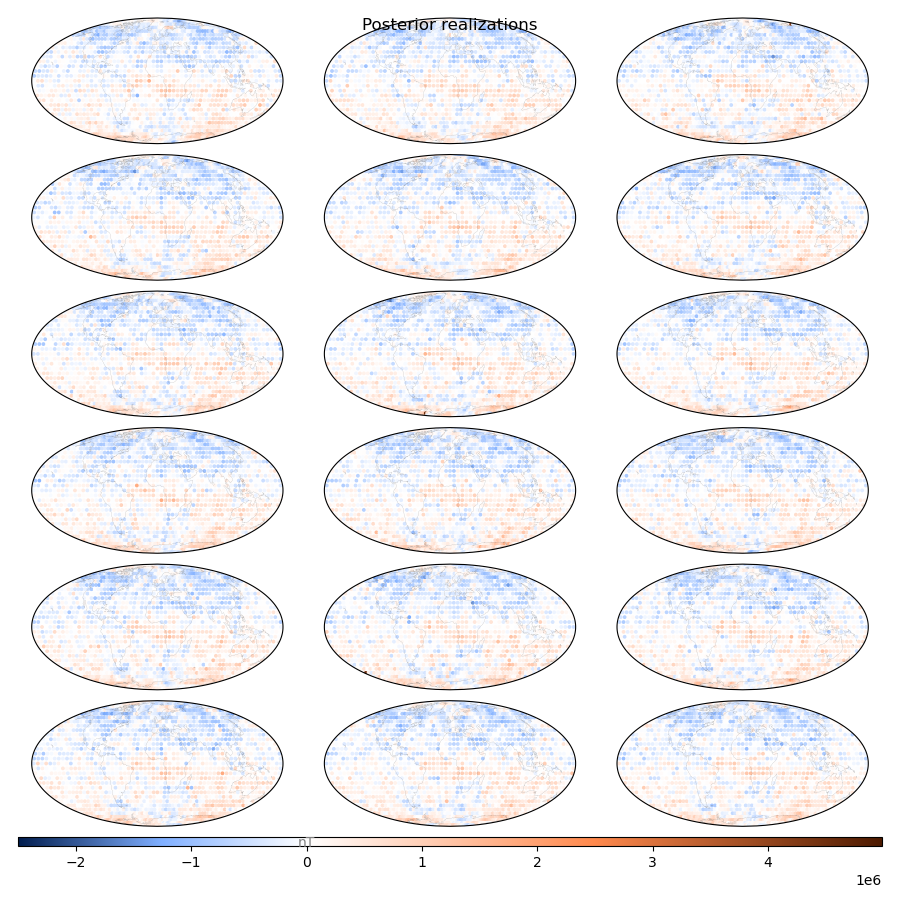

In [18]:
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.lon, core.lat, core.zs, tile_size_row = 6, tile_size_column = 3, 
                        figsize=(9,9), limit_for_SF = 10**6, point_size = 3,
                        left=0.02, bottom=0.06, right=0.98, top=0.98, wspace = 0.05, hspace=0.1, 
                        savefig = False, save_string = "test", 
                        projection = ccrs.Mollweide())

In [19]:
core.g_spec[:3,:10]

array([[-29415.99251101, -29416.05038754, -29416.02469706,
        -29414.5392518 , -29415.42171463, -29416.55162524,
        -29415.12104111, -29415.21429836, -29414.72617461,
        -29415.52010524],
       [ -1463.81800976,  -1463.79845614,  -1463.90650957,
         -1463.90458337,  -1463.65566194,  -1463.77876179,
         -1463.98623982,  -1463.87328976,  -1463.73490733,
         -1463.65964773],
       [  4695.57949653,   4695.63304197,   4695.81524304,
          4695.79629979,   4695.60853261,   4695.97762339,
          4695.77325865,   4695.51210364,   4695.73648141,
          4695.62521553]])

In [20]:
core.g_prior[:3]

array([-51832.174  ,   3138.7632 ,    680.29256])

<IPython.core.display.Javascript object>


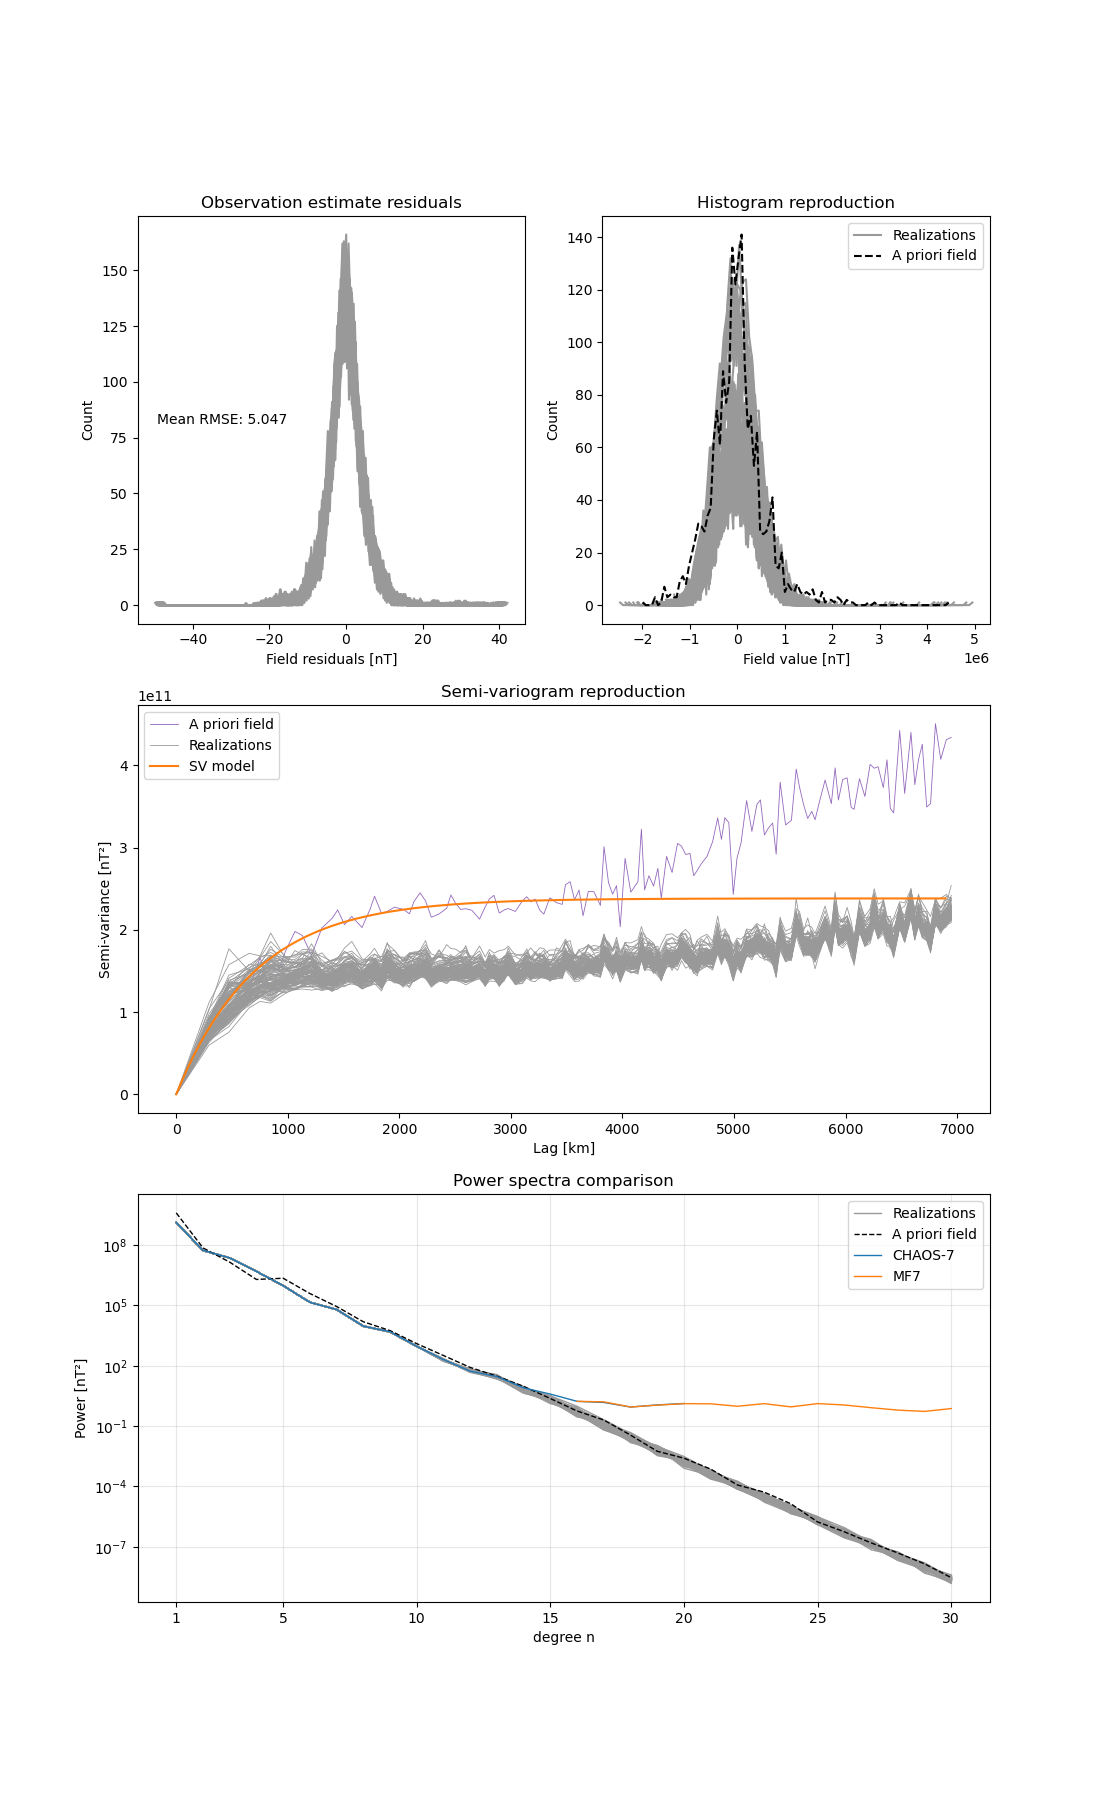

In [21]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = 30, r_at = core.r_cmb)

mt_util.plot_sdssim_reproduce(core, seqsim_res, lags_use = 1000, spec_r_at = core.r_sat,
                              model_dict = {"CHAOS-7", "MF7"}, figsize=(11,18),
                              savefig = False, save_string = "core_A_obs_sh30")

In [22]:
core.grid_glq(nmax = 120, r_at = core.r_cmb)

core.ensemble_B(core.g_spec, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble_glq[:,0,:].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(30)], nmax = 30, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble_glq[:,0].copy()

<IPython.core.display.Javascript object>


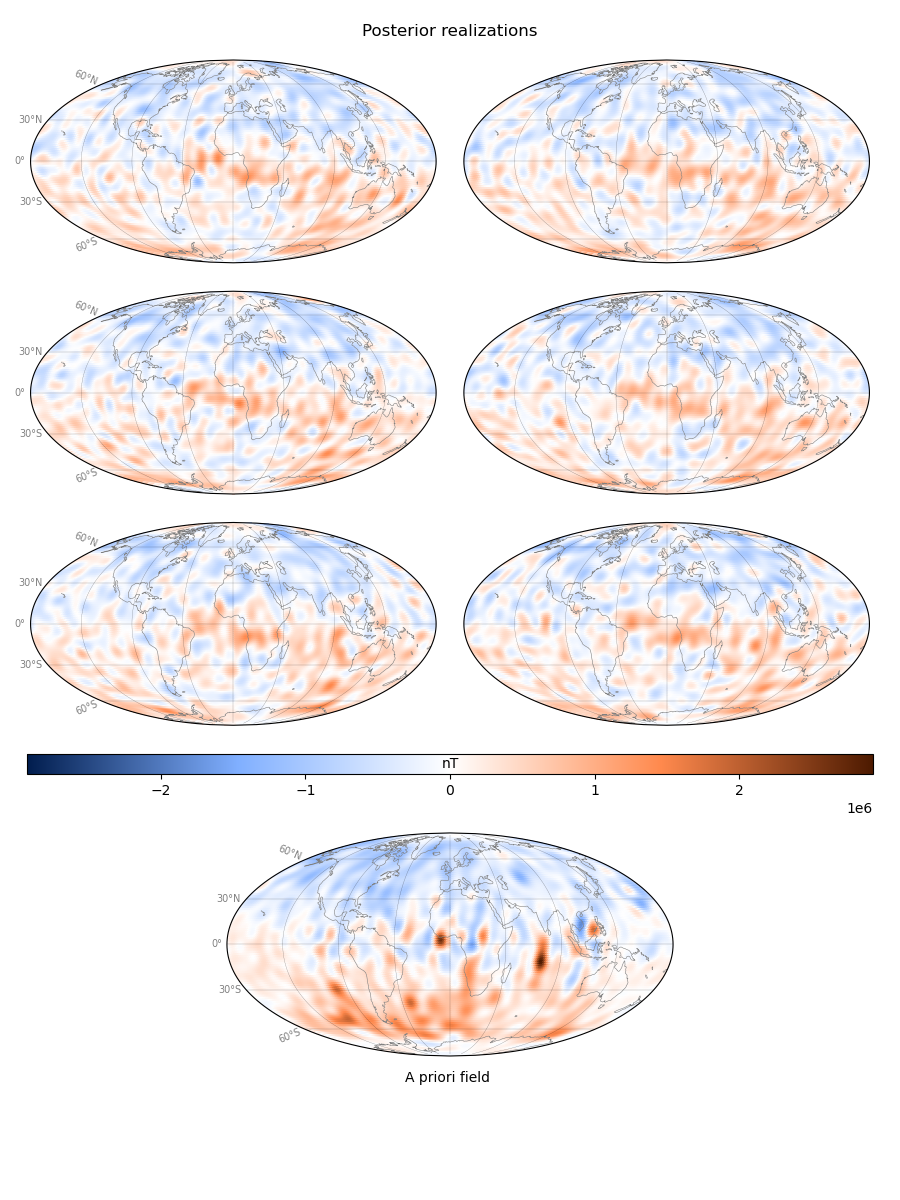

In [29]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_glq_phi, 90-core.grid_glq_theta, zs_eqa, 
                        field_compare = prior_eqa, tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10,
                        coast_width = 0.4, coast_color = "grey",
                        cbar_h = 0.1, cbar_text = "nT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "core_A_obs_sh30", 
                        projection = ccrs.Mollweide(), use_gridlines = True)